In [26]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import barnard_exact, ttest_ind, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load data

In [35]:
transplantation_date = pd.to_datetime('2024-02-02')

data = pd.read_excel('data.xlsx')
data['height_date_1'] = pd.to_datetime(data['height_date_1'], format="%d/%m/%Y")
data['height_date_2'] = pd.to_datetime(data['height_date_2'], format="%d/%m/%Y")
data = pd.merge(data, pd.get_dummies(data['bed_type'], drop_first=True, dtype=float), left_index=True, right_index=True)
data['transplant_to_harvest_days'] = (data['harvest_date'] - data['transplant_date']).dt.days

display(data.head())
display(data.info())

,plant_id,bed_id,bed_type,distance_to_east_wall_mm,distance_to_south_wall_mm,sow_date,transplant_date,survived_to_harvest,height_a_1,height_b_1,...,height_3,height_date_3,harvest_date,yield_g,wall_distance_e_mm,wall_distance_s_mm,species,strain,no-dig,transplant_to_harvest_days
0,1,A,no-dig,NaN,NaN,2024-01-15,2024-02-02,1,70.0,69.0,...,230.0,2024-05-04,2024-08-21,371.3,2000,3800,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,1.0,201.0
1,2,B,dig,NaN,NaN,2024-01-15,2024-02-02,1,70.0,77.0,...,270.0,2024-05-04,2024-07-24,197.4,2000,3200,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,0.0,173.0
2,3,A,no-dig,NaN,NaN,2024-01-15,2024-02-02,0,NaN,NaN,...,NaN,NaT,NaT,NaN,2500,3800,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,1.0,NaN
3,4,B,dig,NaN,NaN,2024-01-15,2024-02-02,1,75.0,75.0,...,270.0,2024-05-04,2024-07-28,270.2,2500,3200,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,0.0,177.0
4,5,C,dig,NaN,NaN,2024-01-15,2024-02-02,1,131.0,135.0,...,410.0,2024-05-04,2024-06-17,431.8,3000,3800,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,0.0,136.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   plant_id                    12 non-null     int64         
 1   bed_id                      12 non-null     object        
 2   bed_type                    12 non-null     object        
 3   distance_to_east_wall_mm    0 non-null      float64       
 4   distance_to_south_wall_mm   0 non-null      float64       
 5   sow_date                    12 non-null     datetime64[ns]
 6   transplant_date             12 non-null     datetime64[ns]
 7   survived_to_harvest         12 non-null     int64         
 8   height_a_1                  9 non-null      float64       
 9   height_b_1                  9 non-null      float64       
 10  height_date_1               9 non-null      datetime64[ns]
 11  height_a_2                  9 non-null      float64       
 

None

# Live to harvest

In [4]:
survival_contingency = pd.crosstab(data.bed_type, data.survived_to_harvest)
survival_contingency

survived_to_harvest,0,1
bed_type,,
dig,1,5
no-dig,2,4


In [5]:
barnard_exact(survival_contingency, alternative='two-sided', pooled=False, n=32)
# Barnard becuase it is more powerful than Fisher and only one margin is fixed
# unpooled as unknown if variences are the same for each group. Pooling assumes the same varience. https://cran.r-project.org/web/packages/Exact/Exact.pdf , https://stats.stackexchange.com/questions/169864/which-test-for-cross-table-analysis-boschloo-or-barnard

BarnardExactResult(statistic=-0.6974858324629157, pvalue=0.7291618462276042)

## Height

In [6]:
for x in ['1', '2']:
    data['height_mean_'+x] = (data['height_a_'+x]+data['height_b_'+x])/2
    data['height_day_'+x] = data['height_date_'+x] - transplantation_date
    data['height_day_str_'+x] = data['height_day_'+x].apply(str)
data

,plant_id,bed_id,bed_type,distance_to_east_wall_mm,distance_to_south_wall_mm,sow_date,transplant_date,survived_to_harvest,height_a_1,height_b_1,...,wall_distance_s_mm,species,strain,no-dig,height_mean_1,height_day_1,height_day_str_1,height_mean_2,height_day_2,height_day_str_2
0,1,A,no-dig,NaN,NaN,2024-01-15,2024-02-02,1,70.0,69.0,...,3800,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,1.0,69.5,34 days,34 days 00:00:00,122.5,59 days,59 days 00:00:00
1,2,B,dig,NaN,NaN,2024-01-15,2024-02-02,1,70.0,77.0,...,3200,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,0.0,73.5,34 days,34 days 00:00:00,104.5,59 days,59 days 00:00:00
2,3,A,no-dig,NaN,NaN,2024-01-15,2024-02-02,0,NaN,NaN,...,3800,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,1.0,NaN,NaT,NaT,NaN,NaT,NaT
3,4,B,dig,NaN,NaN,2024-01-15,2024-02-02,1,75.0,75.0,...,3200,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,0.0,75.0,34 days,34 days 00:00:00,114.5,59 days,59 days 00:00:00
4,5,C,dig,NaN,NaN,2024-01-15,2024-02-02,1,131.0,135.0,...,3800,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,0.0,133.0,34 days,34 days 00:00:00,205.5,59 days,59 days 00:00:00
5,6,D,no-dig,NaN,NaN,2024-01-15,2024-02-02,0,NaN,NaN,...,3200,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,1.0,NaN,NaT,NaT,NaN,NaT,NaT
6,7,C,dig,NaN,NaN,2024-01-15,2024-02-02,0,NaN,NaN,...,3800,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,0.0,NaN,NaT,NaT,NaN,NaT,NaT
7,8,D,no-dig,NaN,NaN,2024-01-15,2024-02-02,1,113.0,114.0,...,3200,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,1.0,113.5,34 days,34 days 00:00:00,166.0,59 days,59 days 00:00:00
8,9,E,dig,NaN,NaN,2024-01-15,2024-02-02,1,113.0,112.0,...,2800,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,0.0,112.5,34 days,34 days 00:00:00,151.0,59 days,59 days 00:00:00
9,10,E,dig,NaN,NaN,2024-01-15,2024-02-02,1,70.0,70.0,...,2200,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,0.0,70.0,34 days,34 days 00:00:00,91.0,59 days,59 days 00:00:00


c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


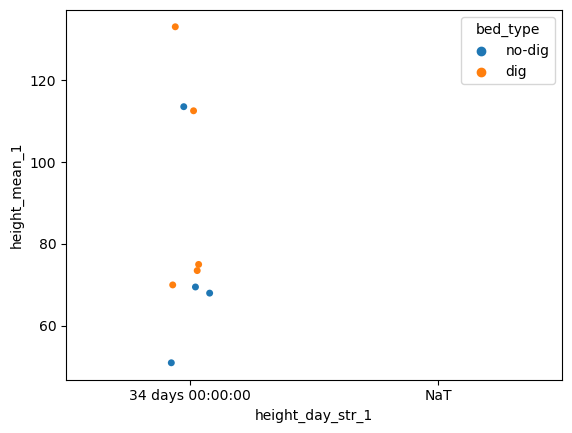

In [7]:
sns.stripplot(data=data, y='height_mean_1', x='height_day_str_1', hue='bed_type', jitter=True)
plt.show()

c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


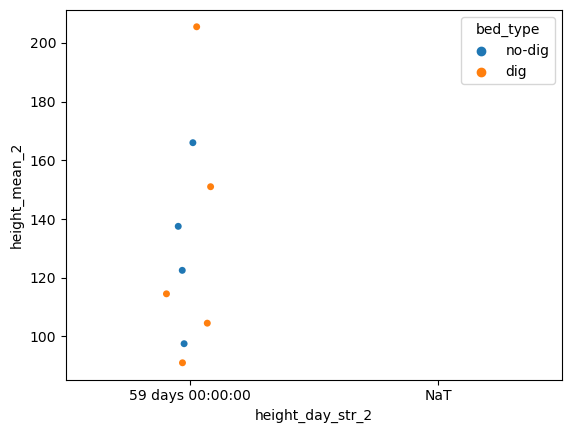

In [8]:
sns.stripplot(data=data, y='height_mean_2', x='height_day_str_2', hue='bed_type', jitter=True)
plt.show()

In [9]:
#30 (34) day
a = data[((data['bed_type']=='dig')&(data['height_mean_1'].isna()==False))]['height_mean_1']
b = data[((data['bed_type']=='no-dig')&(data['height_mean_1'].isna()==False))]['height_mean_1']
ttest_ind(a=a, b=b, equal_var=True, nan_policy='raise', permutations=None, alternative='two-sided', trim=0)

TtestResult(statistic=0.9328677792620035, pvalue=0.3819387891001678, df=7.0)

In [10]:
#60 (59) day
a = data[((data['bed_type']=='dig')&(data['height_mean_2'].isna()==False))]['height_mean_2']
b = data[((data['bed_type']=='no-dig')&(data['height_mean_2'].isna()==False))]['height_mean_2']
ttest_ind(a=a, b=b, equal_var=True, nan_policy='raise', permutations=None, alternative='two-sided', trim=0)

TtestResult(statistic=0.09135860860740895, pvalue=0.9297670668375285, df=7.0)

In [11]:
data['height_date_2']

0    2024-04-01
1    2024-04-01
2           NaT
3    2024-04-01
4    2024-04-01
5           NaT
6           NaT
7    2024-04-01
8    2024-04-01
9    2024-04-01
10   2024-04-01
11   2024-04-01
Name: height_date_2, dtype: datetime64[ns]

In [19]:
measurements = pd.wide_to_long(data,['height_mean', 'height_day_str'], i='plant_id', j='measurement_number', sep='_').reset_index()
measurements.head()

,plant_id,measurement_number,height_b_2,wall_distance_e_mm,height_date_1,wall_distance_s_mm,strain,harvest_date,bed_type,no-dig_y,...,height_day_2,height_3,survived_to_harvest,yield_g,height_date_2,no-dig_x,distance_to_south_wall_mm,sow_date,height_mean,height_day_str
0,1,1,125.0,2000,2024-03-07,3800,Candid Charm F1 Hybrid,2024-08-21,no-dig,True,...,59 days,230.0,1,371.3,2024-04-01,1.0,NaN,2024-01-15,69.5,34 days 00:00:00
1,2,1,105.0,2000,2024-03-07,3200,Candid Charm F1 Hybrid,2024-07-24,dig,False,...,59 days,270.0,1,197.4,2024-04-01,0.0,NaN,2024-01-15,73.5,34 days 00:00:00
2,3,1,NaN,2500,NaT,3800,Candid Charm F1 Hybrid,NaT,no-dig,True,...,NaT,NaN,0,NaN,NaT,1.0,NaN,2024-01-15,NaN,NaT
3,4,1,114.0,2500,2024-03-07,3200,Candid Charm F1 Hybrid,2024-07-28,dig,False,...,59 days,270.0,1,270.2,2024-04-01,0.0,NaN,2024-01-15,75.0,34 days 00:00:00
4,5,1,206.0,3000,2024-03-07,3800,Candid Charm F1 Hybrid,2024-06-17,dig,False,...,59 days,410.0,1,431.8,2024-04-01,0.0,NaN,2024-01-15,133.0,34 days 00:00:00


c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


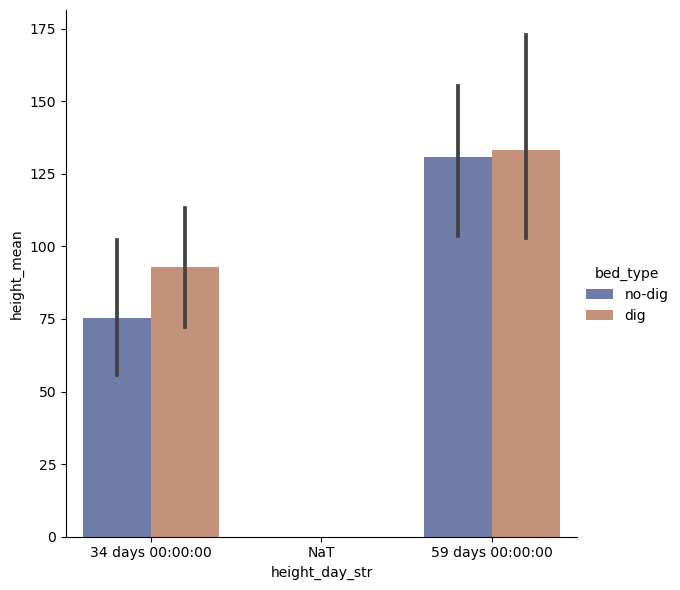

In [14]:
sns.catplot(
    data=measurements, kind="bar",
    x="height_day_str", y="height_mean", hue="bed_type",
    errorbar=("ci", 95), palette="dark", alpha=.6, height=6
)

# Yield

In [43]:
def drop_na(df, variable='yield_g'):
    print(f'There are {len(df)} samples.')
    mask = df[variable].isna()
    print(f'Excluding {sum(mask)} samples with nan {variable}.')
    df = df[mask==False]
    print(f'{len(df)} samples remain.')
    return df

def yield_analysis(df):
    df = drop_na(df)

    a = df[df['bed_type']=='dig']['yield_g']
    b = df[df['bed_type']=='no-dig']['yield_g']

    print()
    print(f'The Dig yield mean is {a.mean()} g')
    print(f'The No-dig yield mean is {b.mean()} g')

    display(ttest_ind(a=a, b=b, equal_var=True, nan_policy='raise', permutations=None, alternative='two-sided', trim=0))

yield_analysis(data)

There are 12 samples.
Excluding 5 samples with nan yield_g.
7 samples remain.

The Dig yield mean is 283.975 g
The No-dig yield mean is 280.8666666666667 g


TtestResult(statistic=0.037780432252569246, pvalue=0.971324775857396, df=5.0)

In [16]:
def yield_linear_regression(df):
    df = drop_na(df)

    mod = smf.ols('yield_g ~ bed_type + wall_distance_e_mm + wall_distance_s_mm', data=df)
    res = mod.fit()

    print(res.summary())
    
yield_linear_regression(data)

There are 12 samples.
Excluding 5 samples with nan yield.
7 samples remain.
                            OLS Regression Results                            
Dep. Variable:                yield_g   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     4.284
Date:                Sat, 24 Aug 2024   Prob (F-statistic):              0.132
Time:                        11:36:52   Log-Likelihood:                -35.687
No. Observations:                   7   AIC:                             79.37
Df Residuals:                       3   BIC:                             79.16
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [17]:
data = pd.merge(data, pd.get_dummies(data['bed_type'], drop_first=True), left_index=True, right_index=True)

In [42]:
def yield_linear_regression(df):
    df = drop_na(df)

    mod = smf.ols('yield_g ~ bed_type', data=df)
    res = mod.fit()

    print(res.summary())
    
yield_linear_regression(data)

There are 12 samples.
Excluding 5 samples with nan yield.
7 samples remain.
                            OLS Regression Results                            
Dep. Variable:                yield_g   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.200
Method:                 Least Squares   F-statistic:                  0.001427
Date:                Sat, 24 Aug 2024   Prob (F-statistic):              0.971
Time:                        12:03:13   Log-Likelihood:                -41.512
No. Observations:                   7   AIC:                             87.02
Df Residuals:                       5   BIC:                             86.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


# Time to harvest

c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


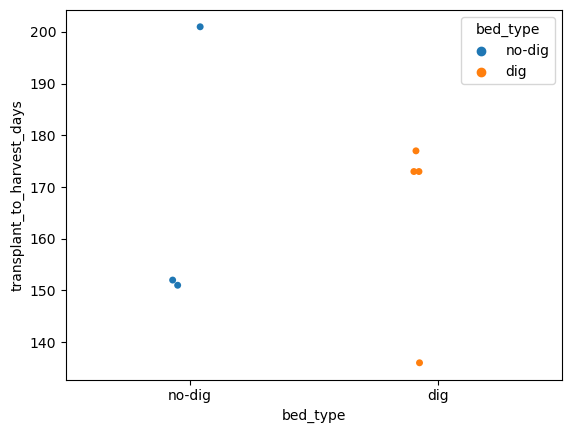

In [50]:
sns.stripplot(data=data, y='transplant_to_harvest_days', x='bed_type', hue='bed_type', jitter=True)
plt.show()

c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


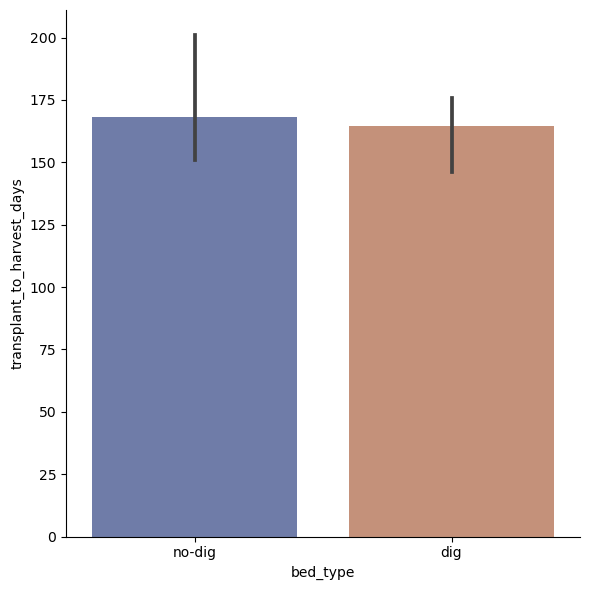

In [41]:
sns.catplot(
    data=data, kind="bar",
    x="bed_type", y="transplant_to_harvest_days",
    errorbar=("ci", 95), palette="dark", alpha=.6, height=6
)

In [46]:
df = drop_na(data, "transplant_to_harvest_days")
mod = smf.ols('transplant_to_harvest_days ~ bed_type', data=df)
res = mod.fit()
print(res.summary())

There are 12 samples.
Excluding 5 samples with nan transplant_to_harvest_days.
7 samples remain.
                                OLS Regression Results                                
Dep. Variable:     transplant_to_harvest_days   R-squared:                       0.007
Model:                                    OLS   Adj. R-squared:                 -0.192
Method:                         Least Squares   F-statistic:                   0.03296
Date:                        Sat, 24 Aug 2024   Prob (F-statistic):              0.863
Time:                                12:06:00   Log-Likelihood:                -30.835
No. Observations:                           7   AIC:                             65.67
Df Residuals:                               5   BIC:                             65.56
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                         coef    

c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [47]:
df = drop_na(data, "transplant_to_harvest_days")
mod = smf.ols('transplant_to_harvest_days ~ bed_type + wall_distance_e_mm + wall_distance_s_mm', data=df)
res = mod.fit()
print(res.summary())

There are 12 samples.
Excluding 5 samples with nan transplant_to_harvest_days.
7 samples remain.
                                OLS Regression Results                                
Dep. Variable:     transplant_to_harvest_days   R-squared:                       0.173
Model:                                    OLS   Adj. R-squared:                 -0.655
Method:                         Least Squares   F-statistic:                    0.2085
Date:                        Sat, 24 Aug 2024   Prob (F-statistic):              0.885
Time:                                12:06:39   Log-Likelihood:                -30.196
No. Observations:                           7   AIC:                             68.39
Df Residuals:                               3   BIC:                             68.17
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                         coef    

c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


# Correlation between height at 30 days and yield

In [22]:
data.head()

,plant_id,bed_id,bed_type,distance_to_east_wall_mm,distance_to_south_wall_mm,sow_date,transplant_date,survived_to_harvest,height_a_1,height_b_1,...,species,strain,no-dig_x,height_mean_1,height_day_1,height_day_str_1,height_mean_2,height_day_2,height_day_str_2,no-dig_y
0,1,A,no-dig,NaN,NaN,2024-01-15,2024-02-02,1,70.0,69.0,...,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,1.0,69.5,34 days,34 days 00:00:00,122.5,59 days,59 days 00:00:00,True
1,2,B,dig,NaN,NaN,2024-01-15,2024-02-02,1,70.0,77.0,...,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,0.0,73.5,34 days,34 days 00:00:00,104.5,59 days,59 days 00:00:00,False
2,3,A,no-dig,NaN,NaN,2024-01-15,2024-02-02,0,NaN,NaN,...,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,1.0,NaN,NaT,NaT,NaN,NaT,NaT,True
3,4,B,dig,NaN,NaN,2024-01-15,2024-02-02,1,75.0,75.0,...,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,0.0,75.0,34 days,34 days 00:00:00,114.5,59 days,59 days 00:00:00,False
4,5,C,dig,NaN,NaN,2024-01-15,2024-02-02,1,131.0,135.0,...,Brassica aleracea var Botrytis,Candid Charm F1 Hybrid,0.0,133.0,34 days,34 days 00:00:00,205.5,59 days,59 days 00:00:00,False


[]

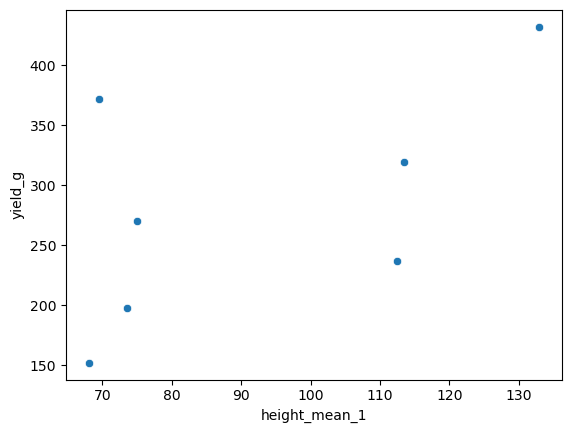

In [24]:
sns.scatterplot(data, x='height_mean_1', y='yield_g')
plt.plot()

In [32]:
df = drop_na(data)
pearsonr(x=df.height_mean_1, y=df.yield_g)

There are 12 samples.
Excluding 5 samples with nan yield.
7 samples remain.


PearsonRResult(statistic=0.5637826683127725, pvalue=0.18744552232846298)

In [25]:
df = drop_na(data)

mod = smf.ols('yield_g ~ bed_type + wall_distance_e_mm + wall_distance_s_mm + height_mean_1', data=df)
res = mod.fit()

print(res.summary())

There are 12 samples.
Excluding 5 samples with nan yield.
7 samples remain.
                            OLS Regression Results                            
Dep. Variable:                yield_g   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     8.455
Date:                Sat, 24 Aug 2024   Prob (F-statistic):              0.109
Time:                        11:45:38   Log-Likelihood:                -31.414
No. Observations:                   7   AIC:                             72.83
Df Residuals:                       2   BIC:                             72.56
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
